In [1]:
%pip install arch
from arch.univariate import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, t, chi2
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import minimize, LinearConstraint

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
url = 'https://raw.githubusercontent.com/HarrisonLam129/QRM/refs/heads/main/QRM-2024-cw2-data.csv'
data = pd.read_csv(url)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, format='%m/%d/%Y')
data = data.rename(columns={'TSLA': 'Close'})

###Preliminary Analysis


In [4]:
data['loss'] = -np.log(data['Close']/data['Close'].shift(1))*100
data.dropna(inplace=True)
data['returns'] = -data['loss']

In [5]:
train, test = data.loc[data.index < '2021-11-26'], data.loc[data.index >= '2021-11-26']

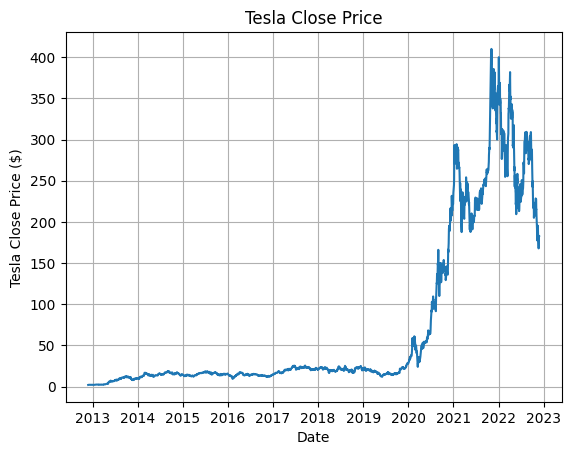

In [6]:
plt.grid()
plt.plot(data['Close'])
plt.ylabel('Tesla Close Price ($)')
plt.xlabel('Date')
plt.title('Tesla Close Price')
plt.show()

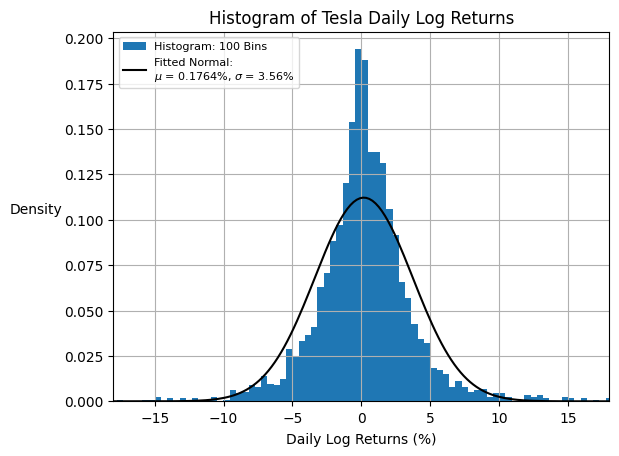

In [7]:
_, bins, _ = plt.hist(data['returns'], density=True, bins=100, label='Histogram: 100 Bins')
plt.title('Histogram of Tesla Daily Log Returns')
plt.ylabel('Density', labelpad=20, rotation=0)
plt.xlabel('Daily Log Returns (%)', labelpad=5)

mu = np.mean(data['returns'])
sigma = np.std(data['returns'], ddof=1)

xs = np.linspace(bins[0], bins[-1], 200)
ys = norm.pdf(xs, loc=mu, scale=sigma)
plt.xlim((-18,18))
plt.plot(xs, ys, c='k', linewidth=1.5,
         label='Fitted Normal: \n' + r'$\mu$ = '+str(round(mu, 4))+'%' +
         r', $\sigma$ = '+str(round(sigma, 2))+'%')
plt.legend(fontsize=8, loc=2)
plt.grid()

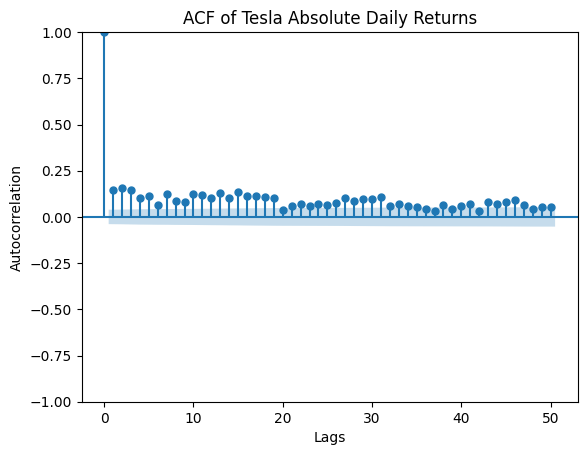

In [8]:
plot_acf(data['returns'], lags = 50, alpha = 0.05)
plt.title('ACF of Tesla Daily Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig('StockACF.png')
plt.close()

plot_acf(abs(data['returns']), lags = 50, alpha = 0.05)
plt.title('ACF of Tesla Absolute Daily Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig('StockACFabs.png')

### Fitting GARCH to linearised losses

In [9]:
model = arch_model(train['loss'])
result = model.fit(disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Wed, Dec 04 2024   Df Residuals:                     2265
Time:                        22:23:38   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.891e-02 [ -0.276,-2.485e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1390  7.816e-02      1.779  7.532e-02  [-1.418e-02,  0.292]
alpha[1]       0.0409  1.327e-02      3.085  2.033e-03 [1.493e-02,6.695e-02]
beta[1]        0.9482  1.768e-02     53.644      0.000     [  0.914,  0.983]
============================================================================

Covariance estimator: robust
"""

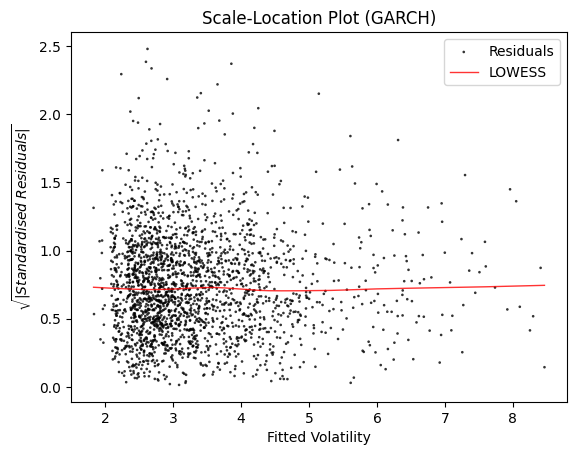

In [10]:
standard_residuals = result.resid/result.conditional_volatility
sns.regplot(x=result.conditional_volatility, y=np.sqrt(abs(standard_residuals)),
            scatter=True, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            scatter_kws={'facecolors':'none', 'edgecolors':'black', 's':0.8})
plt.title('Scale-Location Plot (GARCH)')
plt.xlabel('Fitted Volatility')
plt.ylabel(r'$\sqrt{|Standardised\;Residuals|}$')
plt.legend(['Residuals', 'LOWESS'])
plt.savefig('GARCH Scale-Loc')

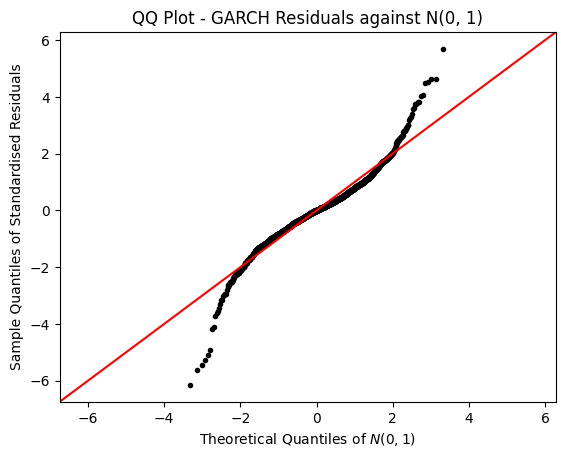

In [11]:
qqplot(standard_residuals, norm, line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title('QQ Plot - GARCH Residuals against N(0, 1)')
plt.xlabel(r'Theoretical Quantiles of $N(0, 1)$')
plt.ylabel('Sample Quantiles of Standardised Residuals')
plt.savefig('GARCH QQ')

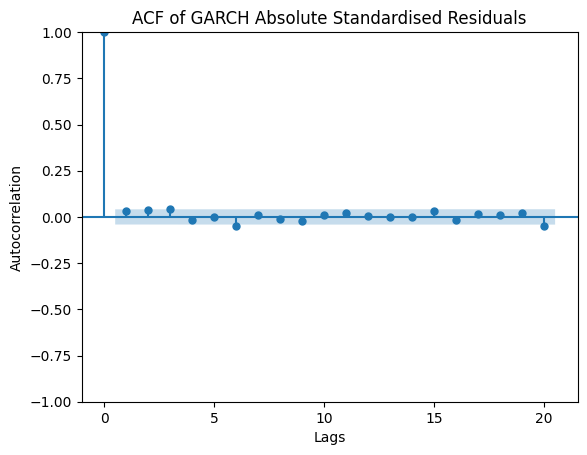

In [12]:
plot_acf(standard_residuals, lags=20, alpha=0.05)
plt.title('ACF of GARCH Standardised Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig('GARCH Norm ACF')
plt.close()

plot_acf(np.abs(standard_residuals), lags=20, alpha=0.05)
plt.title('ACF of GARCH Absolute Standardised Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation');
plt.savefig('GARCH Abs ACF')

In [13]:
train, test = data.loc[data.index < '2021-11-26'], data.loc[data.index >= '2021-11-26']

### Fitting t-distribution to residuals
Can't fit using kurtosis because t-distribution has infinite kurtosis for df <= 4 \\
Use scipy.optimize to fit t-distribution with least squares and maximum likelihood

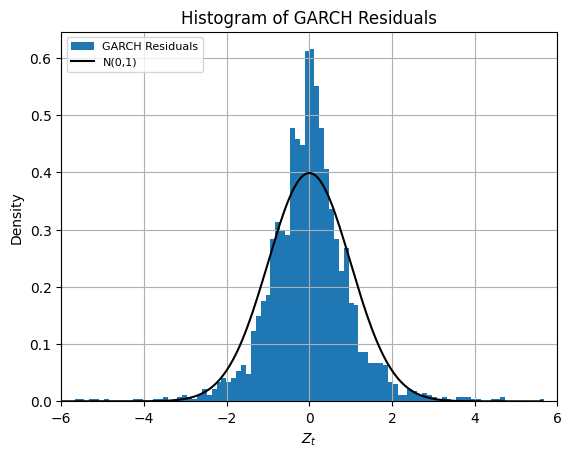

In [14]:
epdf, bins, _ = plt.hist(standard_residuals, bins=100, density=True,label = 'GARCH Residuals')
x_lim1, x_lim2 = min(bins), max(bins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.title('Histogram of GARCH Residuals')
plt.xlabel('$Z_t$')
plt.ylabel('Density')

xs = np.linspace(bins[0], bins[-1], 200)
ys = norm.pdf(xs, loc=0, scale=1)
plt.xlim((-6,6))
plt.plot(xs, ys, c='k', linewidth=1.5,
         label='N(0,1)')
plt.legend(fontsize=8, loc=2)
plt.grid()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04778109775106025
            Iterations: 9
            Function evaluations: 21
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3033.9445474609242
            Iterations: 9
            Function evaluations: 22
            Gradient evaluations: 9
Fitted df (Least Squares):  3.682
Fitted df (Maximum Likelihood):  3.8


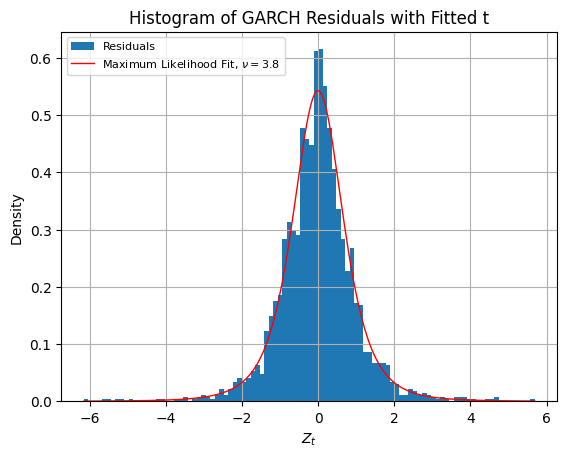

In [15]:
def LS(nu):
    return np.sum((t.pdf(bins, df=nu, loc=0, scale=np.sqrt((nu-2)/nu))-epdf)**2)

def LL(nu):
    return np.sum(np.log(t.pdf(standard_residuals, df=nu, loc=0, scale=np.sqrt((nu-2)/nu))))

y0 = [5]
range_constraint = [[2.01, np.inf]]
least_squares_t_fit = minimize(lambda y: LS(y[0]), y0, method='SLSQP',
                               bounds=range_constraint, options={'disp': True})
fitted_nu = least_squares_t_fit.x[0]
max_LL_t_fit = minimize(lambda y: -LL(y[0]), y0, method='SLSQP',
                        bounds=range_constraint, options={'disp': True})
fitted_nu_LL = max_LL_t_fit.x[0]
print('Fitted df (Least Squares): ', round(fitted_nu, 3))
print('Fitted df (Maximum Likelihood): ', round(fitted_nu_LL, 3))
xs = np.linspace(x_lim1, x_lim2, 200)
ys = t.pdf(xs, df=fitted_nu, loc=0, scale=np.sqrt((fitted_nu-2)/fitted_nu))
ys2 = t.pdf(xs, df=fitted_nu_LL, loc=0, scale=np.sqrt((fitted_nu_LL-2)/fitted_nu_LL))
plt.hist(standard_residuals, bins=100, density=True, label='Residuals')
#plt.plot(xs, ys, c='r', linewidth=1, label=f'Least Squares Fit, $\\nu={round(fitted_nu, 3)}$')
plt.plot(xs, ys2, c='r', linewidth=1, label=f'Maximum Likelihood Fit, $\\nu={round(fitted_nu_LL, 3)}$')
plt.title('Histogram of GARCH Residuals with Fitted t')
plt.xlabel('$Z_t$')
plt.ylabel('Density')
plt.legend(loc=2, fontsize=8)
plt.grid()

plt.savefig('GARCH Hist Fitted t')

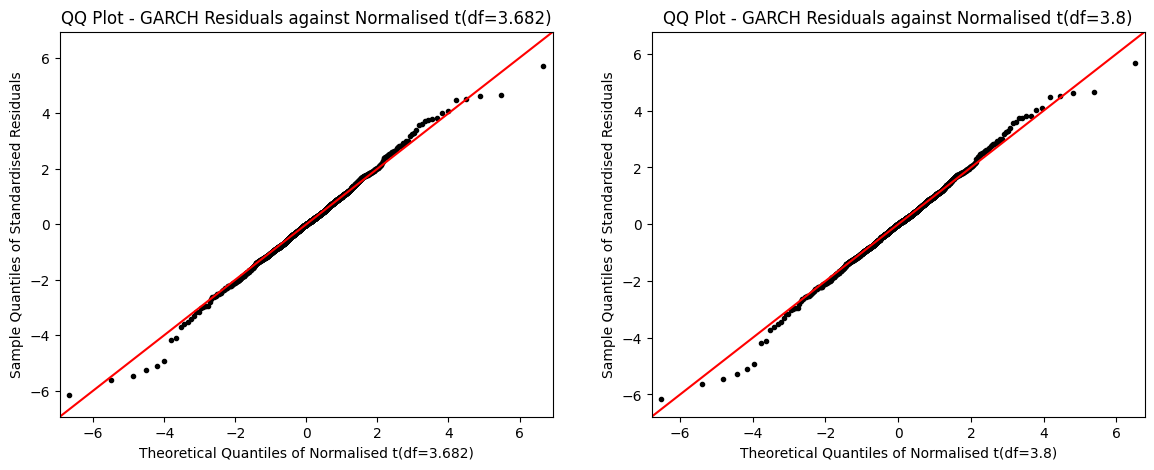

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
qqplot(standard_residuals, t(df=fitted_nu, scale=np.sqrt((fitted_nu-2)/fitted_nu)), line='45', marker='.', markerfacecolor='k', markeredgecolor='k', ax=axs[0]);
qqplot(standard_residuals, t(df=fitted_nu_LL, scale=np.sqrt((fitted_nu_LL-2)/fitted_nu_LL)), line='45', marker='.', markerfacecolor='k', markeredgecolor='k', ax=axs[1]);
axs[0].set_title(f'QQ Plot - GARCH Residuals against Normalised t(df={round(fitted_nu, 3)})')
axs[1].set_title(f'QQ Plot - GARCH Residuals against Normalised t(df={round(fitted_nu_LL, 3)})')
axs[0].set_xlabel(f'Theoretical Quantiles of Normalised t(df={round(fitted_nu, 3)})')
axs[0].set_ylabel('Sample Quantiles of Standardised Residuals')
axs[1].set_xlabel(f'Theoretical Quantiles of Normalised t(df={round(fitted_nu_LL, 3)})')
axs[1].set_ylabel('Sample Quantiles of Standardised Residuals');
plt.savefig('t Fit QQ')

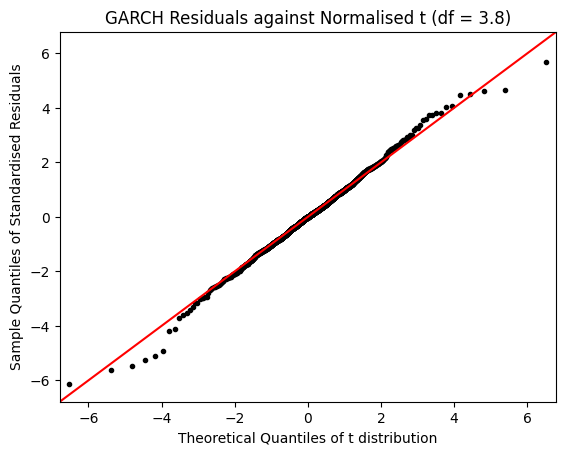

In [17]:
qqplot(standard_residuals, t(df=fitted_nu_LL, scale=np.sqrt((fitted_nu_LL-2)/fitted_nu_LL)), line='45', marker='.', markerfacecolor='k', markeredgecolor='k')
plt.title('GARCH Residuals against Normalised t (df = 3.8)')
plt.xlabel(r'Theoretical Quantiles of t distribution')
plt.ylabel('Sample Quantiles of Standardised Residuals')
plt.show()

The fitted values for $\nu$ are very similar, therefore we will simply use the result from maximum likelihood from now on.

### Compute mean excess function to fit GPD

In [18]:
sample_mean_excess = []
for x in standard_residuals:
    excess = standard_residuals[standard_residuals > x]
    sample_mean_excess.append((excess-x).mean())

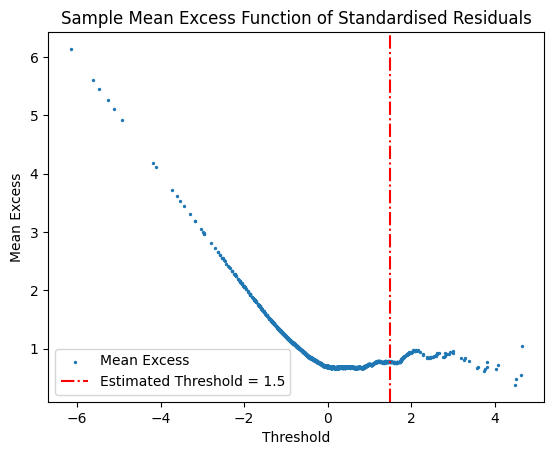

In [19]:
plt.scatter(standard_residuals, sample_mean_excess, s=2)
plt.xlabel('v (Threshold)')
threshold = 1.5
plt.axvline(x=threshold, c='red', linestyle='-.')
plt.title('Sample Mean Excess Function of Standardised Residuals')
plt.xlabel('Threshold')
plt.ylabel('Mean Excess')
plt.legend(['Mean Excess', f'Estimated Threshold = {threshold}']);
plt.savefig('Sample Mean Excess Function')

In [20]:
excess = standard_residuals[standard_residuals > threshold]
excess_distribution = []
for x in excess:
    excess_distribution.append(len(excess[excess <= x])/len(excess))

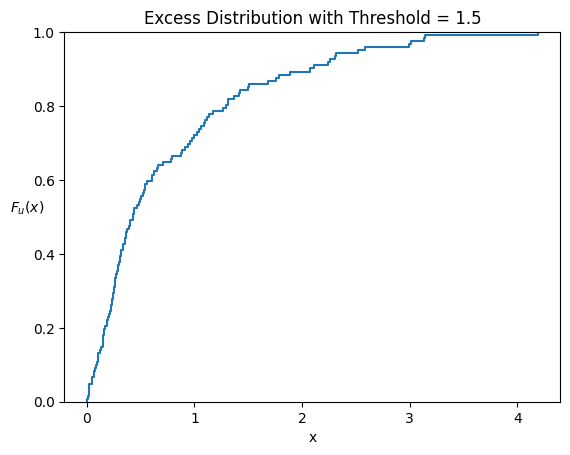

In [21]:
excess = standard_residuals[standard_residuals > threshold]
plt.ecdf(sorted(excess-threshold))
plt.title(f'Excess Distribution with Threshold = {threshold}')
plt.xlabel('x')
plt.ylabel('$F_u(x)$', rotation=0);
xF = excess.max()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 89.51228592245482
            Iterations: 9
            Function evaluations: 30
            Gradient evaluations: 9
xi:  0.0893
beta:  0.7007


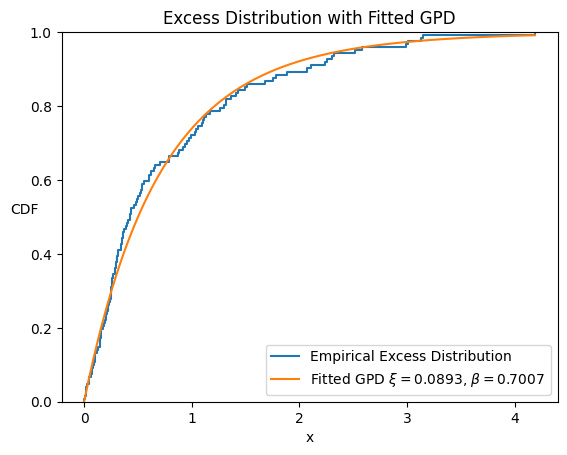

In [22]:
def LL(xi, b):
    if xi != 0:
        return -len(excess)*np.log(b)-(1+1/xi)*(np.log(1+xi*(excess-threshold)/b)).sum()
    else:
        return -len(excess)*np.log(b)-np.sum(excess-threshold)/b

y0 = [0, 1]
linear_constraint = LinearConstraint([xF, 1], lb=0, ub=np.inf)
range_constraint = [[-np.inf, np.inf], [0.001, np.inf]]
max_LL = minimize(lambda y: -LL(y[0], y[1]), y0, method='SLSQP',
                  bounds=range_constraint, constraints=linear_constraint, options={'disp': True})
print('xi: ', round(max_LL.x[0], 4))
print('beta: ', round(max_LL.x[1], 4))
xi, beta = max_LL.x
x_range = np.linspace(0, xF-threshold, 100)
ys3 = 1-(1+xi*x_range/beta)**(-1/xi)

plt.ecdf(sorted(excess-threshold))
plt.title(f'Excess Distribution with Fitted GPD')
plt.xlabel('x')
plt.ylabel('CDF', rotation=0);
plt.plot(x_range, ys3)
plt.legend(['Empirical Excess Distribution', f'Fitted GPD $\\xi={round(xi, 4)}$, $\\beta={round(beta, 4)}$'])
plt.savefig('Excess Distribution Fitted GPD')

In [23]:
mu, omega, alpha, beta = result.params.values
test.loc[:, 'variance_forecast'] = 0.0
test.loc[test.index[0], 'variance_forecast'] = omega+alpha*(train['loss'].iloc[-1]**2)+beta*(result.conditional_volatility[-1]**2)
for i in range(1, len(test.index)):
    test.loc[test.index[i], 'variance_forecast'] = omega+alpha*(test['loss'].iloc[i-1]**2)+beta*test['variance_forecast'].iloc[i-1]
test.loc[:, 'vol_forecast'] = np.sqrt(test['variance_forecast'])

confs = [0.95, 0.99]
# Normal
norm_VaR = [norm.ppf(conf) for conf in confs]
norm_ES = [norm.pdf(norm.ppf(conf))/(1-conf) for conf in confs]
for i, conf in enumerate(confs):
    test.loc[:, f'Normal_VaR_{int(conf*100)}'] = mu+test['vol_forecast']*norm_VaR[i]
    test.loc[:, f'Normal_ES_{int(conf*100)}'] = mu+test['vol_forecast']*norm_ES[i]

# T
nu = fitted_nu_LL
def norm_t_pdf(x):
    return t.pdf(x, df=nu, scale=np.sqrt((nu-2)/nu))
def norm_t_cdf(x):
    return t.cdf(x, df=nu, scale=np.sqrt((nu-2)/nu))
def norm_t_ppf(x):
    return t.ppf(x, df=nu, scale=np.sqrt((nu-2)/nu))

t_VaR = [norm_t_ppf(conf) for conf in confs]
t_ES = [(norm_t_pdf(norm_t_ppf(conf))/(1-conf))*(((nu-2)+norm_t_ppf(conf)**2)/(nu-1)) for conf in confs]
for i, conf in enumerate(confs):
    test.loc[:, f't_VaR_{int(conf*100)}'] = mu+test['vol_forecast']*t_VaR[i]
    test.loc[:, f't_ES_{int(conf*100)}'] = mu+test['vol_forecast']*t_ES[i]

# GPD
F_u = len(standard_residuals[standard_residuals <= threshold])/2265
GPD_VaR = [threshold+(beta/xi)*(((1-conf)/(1-F_u))**(-xi)-1) for conf in confs]
GPD_ES = [(GPD_VaR[i]+beta-xi*threshold)/(1-xi) for i, conf in enumerate(confs)]
for i, conf in enumerate(confs):
    test.loc[:, f'GPD_VaR_{int(conf*100)}'] = mu+test['vol_forecast']*GPD_VaR[i]
    test.loc[:, f'GPD_ES_{int(conf*100)}'] = mu+test['vol_forecast']*GPD_ES[i]

<ipython-input-23-8784fc809d11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'variance_forecast'] = 0.0
<ipython-input-23-8784fc809d11>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test.loc[test.index[0], 'variance_forecast'] = omega+alpha*(train['loss'].iloc[-1]**2)+beta*(result.conditional_volatility[-1]**2)
<ipython-input-23-8784fc809d11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [26]:
names = ['Normal', 't', 'GPD']
for i in range(3):
    fig, ax = plt.subplots()
    plt.ylabel('Loss (%)')
    ax.plot(test[f'{names[i]}_ES_99'], c='r', linestyle=':')
    ax.plot(test[f'{names[i]}_VaR_99'], c='r', linewidth=0.7)
    ax.plot(test[f'{names[i]}_ES_95'], c='b', linestyle=':')
    ax.plot(test[f'{names[i]}_VaR_95'], c='b', linewidth=0.7)
    ax.plot(np.maximum(test['loss'], 0), c='k', linewidth=0.4, alpha=0.5)
    ax.set_title(f'Losses, VaR and ES ({names[i]}) on Test Set')
    ax.set_xlabel('Date')
    ax.legend(['99% ES', '99% VaR', '95% ES', '95% VaR', 'Actual Loss'], loc=1, fontsize=8)
    ax.grid(axis='y')
    ax.tick_params(labelleft=True)
    temp_ax = ax.twinx()
    violations_95 = test.loc[test['loss'] > test[f'{names[i]}_VaR_95']]
    s1 = temp_ax.scatter(violations_95.index, violations_95['loss'], c='b', marker=6,
                         label=f'95% VaR Violations ({round(100*len(violations_95)/len(test), 2)}%)')
    violations_99 = test.loc[test['loss'] > test[f'{names[i]}_VaR_99']]
    s2 = temp_ax.scatter(violations_99.index, violations_99['loss'], c='r', marker=6,
                         label=f'99% VaR Violations ({round(100*len(violations_99)/len(test), 2)}%)')
    temp_ax.legend(handles=[s2, s1], loc=2)
    ax.set_ylim(0, 25)
    temp_ax.set_ylim(0, 25)
    plt.savefig(f'{names[i]} VaR ES.png')
    plt.close()

In [25]:
significance_level = 0.05
print(len(test.index))
for name in names:
    print(f'{name}:')
    for conf in confs:
        violations = test[test['loss'] > test[f'{name}_VaR_{int(conf*100)}']]
        print(name, conf, len(violations))
        mle = (len(test.index)-len(violations))/len(test.index)
        L0 = (len(test.index)-len(violations))*np.log(conf) + len(violations)*np.log(1-conf)
        L1 = (len(test.index)-len(violations))*np.log(mle) + len(violations)*np.log(1-mle)
        chi_stat = 2*(L1-L0)
        print(f'Chi-squared statistic: {round(chi_stat, 4)}')
        p_value = 1 - chi2.cdf(chi_stat, df=1)
        if p_value <= significance_level:
            print(f'p-value = {round(p_value, 5)}, reject null')
        else:
            print(f'p-value = {round(p_value, 5)}, do not reject null')
    print('-'*15)

252
Normal:
Normal 0.95 22
Chi-squared statistic: 6.0972
p-value = 0.01354, reject null
Normal 0.99 4
Chi-squared statistic: 0.7451
p-value = 0.38804, do not reject null
---------------
t:
t 0.95 25
Chi-squared statistic: 10.1126
p-value = 0.00147, reject null
t 0.99 3
Chi-squared statistic: 0.087
p-value = 0.76797, do not reject null
---------------
GPD:
GPD 0.95 24
Chi-squared statistic: 8.6808
p-value = 0.00322, reject null
GPD 0.99 2
Chi-squared statistic: 0.1166
p-value = 0.73271, do not reject null
---------------
